# Homework4 - datatalks.club - Rui Pinto

In [2]:
## imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

- 'age',
- 'job',
- 'marital',
- 'education',
- 'balance',
- 'housing',
- 'contact',
- 'day',
- 'month',
- 'duration',
- 'campaign',
- 'pdays',
- 'previous',
- 'poutcome',
- 'y'

In [5]:
df = pd.read_csv('bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
# features and target
X = df.drop(columns=["default","loan","y"])
y = df["y"] #target

In [39]:
y.value_counts() #imbalanced dataset

y
no     39922
yes     5289
Name: count, dtype: int64

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [7]:
from sklearn.model_selection import train_test_split

# split data into train/val/test with 60%/20%/20% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [8]:
# checking ratio of split
print("train ratio: ", len(X_train)/len(X))
print("val ratio: ", len(X_val)/len(X))
print("test ratio: ", len(X_test)/len(X))

train ratio:  0.5999867288934109
val ratio:  0.19999557629780362
test ratio:  0.20001769480878548


## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [16]:
from sklearn.metrics import roc_auc_score

num_features_selection = ['balance', 'day', 'duration','previous']

filtered_train = X_train[num_features_selection]


# Compute AUC for each numerical feature
auc_scores = {}
for feature in num_features_selection:
    auc = roc_auc_score(y_train.map({'yes': 1, 'no': 0}), filtered_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train.map({'yes': 1, 'no': 0}), -filtered_train[feature])
    auc_scores[feature] = auc


auc_scores

{'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'previous': 0.5985653242764153}

In [17]:
# Find the feature with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
best_feature, auc_scores[best_feature]

('duration', 0.8147002759670778)

# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [19]:
print(X.columns[X.dtypes != 'object'].tolist())
print(X.columns[X.dtypes == 'object'].tolist())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

# label encoding for target
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

numerical = X.columns[X.dtypes != 'object'].tolist()
categorical = X.columns[X.dtypes == 'object'].tolist()


def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [28]:
# train on validation data
dv, model = train(X_val, y_val)

y_pred = predict(X_val, dv, model)

auc = round(roc_auc_score(y_val, y_pred),4)

print("For validation data the AUC of model is: ", auc)

For validation data the AUC of model is:  0.8999


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

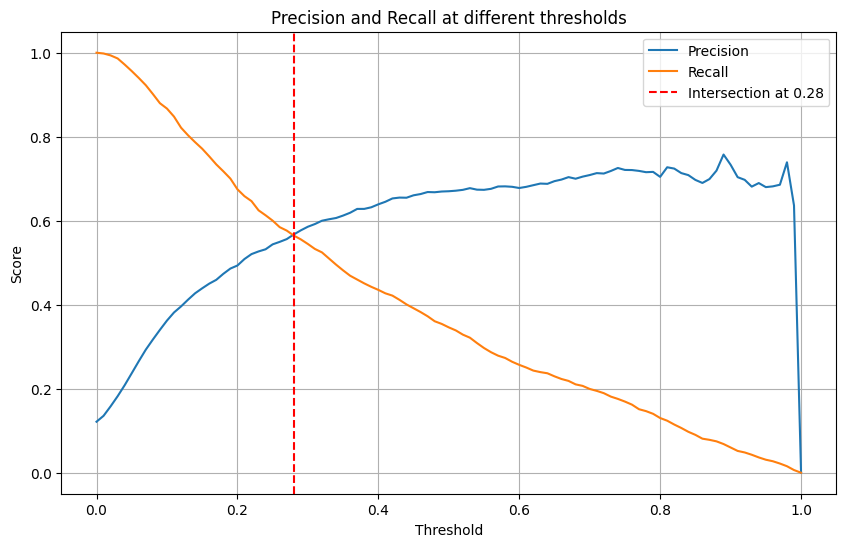

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store precision and recall values
precisions = []
recalls = []

# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred_threshold, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_threshold, zero_division=0))

# Convert lists to numpy arrays for easy manipulation
precisions = np.array(precisions)
recalls = np.array(recalls)

# Restrict the search to avoid start and end (e.g., 0.1 to 0.9)
start_index = int(len(thresholds) * 0.1)
end_index = int(len(thresholds) * 0.9)

# Find the threshold where precision and recall are closest in the middle range
intersection_index = np.argmin(np.abs(precisions[start_index:end_index] - recalls[start_index:end_index])) + start_index
intersection_threshold = thresholds[intersection_index]

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

# Plot vertical line at intersection point
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label=f'Intersection at {intersection_threshold:.2f}')

# Add labels, title, legend, and grid
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall at different thresholds')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

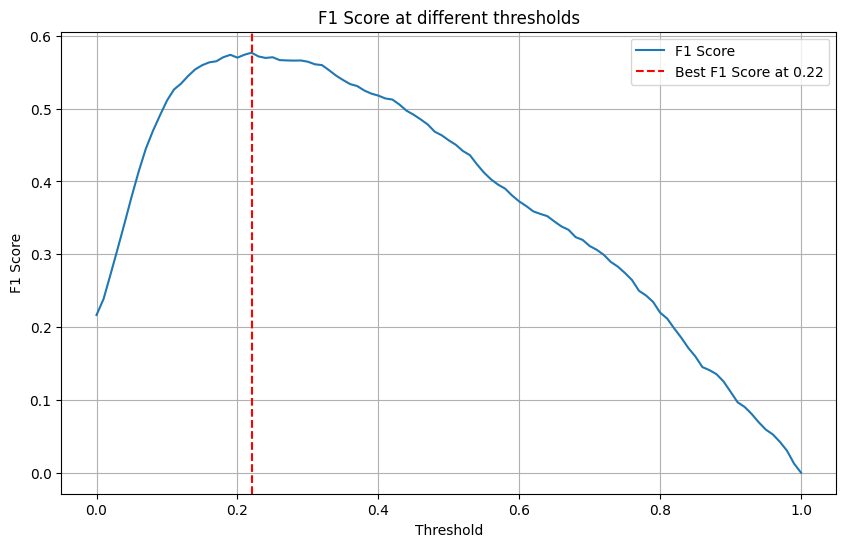

In [37]:
# Initialize lists to store precision and recall values
f1_scores = []

# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_threshold, zero_division=0))
    
# Convert lists to numpy arrays for easy manipulation
f1_scores = np.array(f1_scores)

# Find the threshold where F1 score is highest
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1_score = f1_scores[best_index]

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')

# Plot vertical line at best threshold
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best F1 Score at {best_threshold:.2f}')

# Add labels, title, legend, and grid
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score at different thresholds')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
    

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [40]:
from sklearn.model_selection import KFold

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize lists to store AUC values
auc_values = []

# Iterate over each fold
for train_idx, val_idx in kf.split(X):
    # Split data
    X_train = X.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]
    
    # Train the model
    dv, model = train(X_train, y_train)
    
    # Predict the probabilities
    y_pred = predict(X_val, dv, model)
    
    # Calculate the AUC
    auc = roc_auc_score(y_val, y_pred)
    auc_values.append(auc)

Mean AUC: 0.906
Standard Deviation of AUC: 0.004


In [41]:
auc_values

[0.9070399694971195,
 0.8992198585962373,
 0.9053886519539699,
 0.9124077649077649,
 0.9069891685217052]

In [42]:
# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(auc_values)
std_auc = np.std(auc_values)

print(f'Mean AUC: {mean_auc:.3f}')
print(f'Standard Deviation of AUC: {std_auc:.3f}')

Mean AUC: 0.906
Standard Deviation of AUC: 0.004


## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1
  
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [43]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    auc_values = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        dv, model = train(X_train, y_train, C=C)
        y_pred = predict(X_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        auc_values.append(auc)
    
    mean_auc = np.mean(auc_values)
    std_auc = np.std(auc_values)
    results[C] = (mean_auc, std_auc)

In [44]:
results

{1e-06: (0.9062090826953593, 0.004224805984974045),
 0.001: (0.9062090826953593, 0.004224805984974045),
 1: (0.9062090826953593, 0.004224805984974045)}

In [46]:
# Find the best C
best_C = min(results, key=lambda k: (results[k][0], -results[k][1]))

for C, (mean_auc, std_auc) in results.items():
    print(f'C={C}: Mean AUC={mean_auc}, Std AUC={std_auc}')

print(f'Best C: {best_C}')

C=1e-06: Mean AUC=0.9062090826953593, Std AUC=0.004224805984974045
C=0.001: Mean AUC=0.9062090826953593, Std AUC=0.004224805984974045
C=1: Mean AUC=0.9062090826953593, Std AUC=0.004224805984974045
Best C: 1e-06


If the C parameter is the smallest one, it means that the regularization strength is the highest. In logistic regression, the C parameter is the inverse of the regularization strength, so a smaller C value implies stronger regularization. Stronger regularization can help prevent overfitting by penalizing large coefficients, leading to a simpler model that may generalize better to unseen data.